In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD


# DATA 3950 Project 1
### Group 10: Chuan Yong Guo, Sijia Hao

## Project 1 - NLP and Text Classification

For this project you will need to classify some angry comments into their respective category of angry. The process that you'll need to follow is (roughly):
<ol>
<li> Use NLP techniques to process the training data. 
<li> Train model(s) to predict which class(es) each comment is in.
    <ul>
    <li> A comment can belong to any number of classes, including none. 
    </ul>
<li> Generate predictions for each of the comments in the test data. 
<li> Write your test data predicitions to a CSV file, which will be scored. 
</ol>

You can use any models and NLP libraries you'd like. Think aobut the problem, look back to see if there's anything that might help, give it a try, and see if that helps. We've regularly said we have a "toolkit" of things that we can use, we generally don't know which ones we'll need, but here you have a pretty simple goal - if it makes it more accurate, it helps. There's not one specific solution here, there are lots of things that you could do. 

## Training Data

Use the training data to train your prediction model(s). Each of the classification output columns (toxic to the end) is a human label for the comment_text, assessing if it falls into that category of "rude". A comment may fall into any number of categories, or none at all. Membership in one output category is <b>independent</b> of membership in any of the other classes (think about this when you plan on how to make these predictions - it may also make it easier to split work amongst a team...). 

In [32]:
#Visualize dataset
train_df = pd.read_csv("train.csv.zip")
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [33]:
#Replace '\n' with ' ', because it just indicates a new line, don't want to use '\n' as a variable for modelling. 
df = train_df.replace('\n', ' ', regex=True)

#Add a column for 'None' as a target.
df["none"] = ((df.toxic | df.severe_toxic | df.obscene | df.threat | df.insult | df.identity_hate) == 0)
df["none"] = df["none"].astype(int)
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,""" More I can't make any real suggestions on im...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,1
159567,ffea4adeee384e90,You should be ashamed of yourself That is a ...,0,0,0,0,0,0,1
159568,ffee36eab5c267c9,"Spitzer Umm, theres no actual article for pr...",0,0,0,0,0,0,1
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,1


### Predictive Model For 'Toxic'

c:\Users\billg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.96      1.00      0.97     36079
           1       0.93      0.56      0.70      3814

    accuracy                           0.95     39893
   macro avg       0.94      0.78      0.84     39893
weighted avg       0.95      0.95      0.95     39893



<AxesSubplot:>

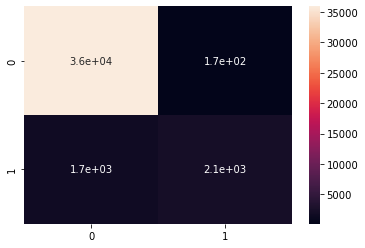

In [35]:
#Train, test split, try different models, pick best model.
model_toxic = LogisticRegression()
#model_toxic = SVC()
#model_toxic = RandomForestClassifier()

vec_tf = TfidfVectorizer(ngram_range=(1,2), stop_words="english", strip_accents="unicode")
#svd_tmp = TruncatedSVD(n_components=10)
y_toxic = np.array(df["toxic"]).reshape(-1,1)
x_toxic = df["comment_text"]

X_train, X_test, y_train, y_test = train_test_split(x_toxic, y_toxic)

pipe_toxic = Pipeline([("vect", vec_tf),("model", model_toxic)])


pipe_toxic.fit(X_train, y_train.ravel())
pred_toxic = pipe_toxic.predict(X_test)

print(classification_report(y_test, pred_toxic))
sns.heatmap(confusion_matrix(y_test, pred_toxic), annot=True)

### Predictive Model For 'Severe_Toxic'

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     39473
           1       0.49      0.15      0.23       420

    accuracy                           0.99     39893
   macro avg       0.74      0.57      0.61     39893
weighted avg       0.99      0.99      0.99     39893



<AxesSubplot:>

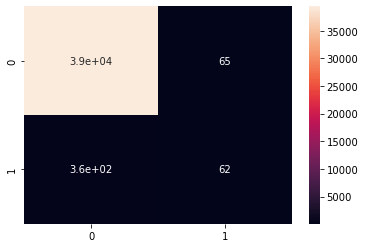

In [36]:
#Train, test split, try different models, pick best model.
#model_severe = LogisticRegression()
#model_severe = SVC()
model_severe = RandomForestClassifier()

vec_tf = TfidfVectorizer(ngram_range=(1,2), stop_words="english", strip_accents="unicode")
svd_tmp = TruncatedSVD(n_components=10)
y_severe = np.array(df["severe_toxic"]).reshape(-1,1)
x_severe = df["comment_text"]

X_train, X_test, y_train, y_test = train_test_split(x_severe, y_severe)

pipe_severe = Pipeline([("vect", vec_tf), ("svd", svd_tmp),("model", model_severe)])


pipe_severe.fit(X_train, y_train.ravel())
pred_severe = pipe_severe.predict(X_test)

print(classification_report(y_test, pred_severe))
sns.heatmap(confusion_matrix(y_test, pred_severe), annot=True)

### Predictive Model For 'Obscene'

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     37773
           1       0.92      0.60      0.73      2120

    accuracy                           0.98     39893
   macro avg       0.95      0.80      0.86     39893
weighted avg       0.97      0.98      0.97     39893



<AxesSubplot:>

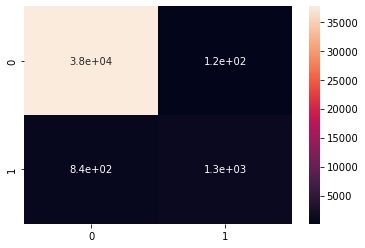

In [37]:
#Train, test split, try different models, pick best model.
model_obscene = LogisticRegression()
#model_obscene = SVC()
#model_obscene = RandomForestClassifier()

vec_tf = TfidfVectorizer(ngram_range=(1,2), stop_words="english", strip_accents="unicode")
#svd_tmp = TruncatedSVD(n_components=10)
y_obscene = np.array(df["obscene"]).reshape(-1,1)
x_obscene = df["comment_text"]

X_train, X_test, y_train, y_test = train_test_split(x_obscene, y_obscene)

pipe_obscene = Pipeline([("vect", vec_tf),("model", model_obscene)])


pipe_obscene.fit(X_train, y_train.ravel())
pred_obscene = pipe_obscene.predict(X_test)

print(classification_report(y_test, pred_obscene))
sns.heatmap(confusion_matrix(y_test, pred_obscene), annot=True)

### Predictive Model For 'Threat'

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39766
           1       0.86      0.05      0.09       127

    accuracy                           1.00     39893
   macro avg       0.93      0.52      0.54     39893
weighted avg       1.00      1.00      1.00     39893



<AxesSubplot:>

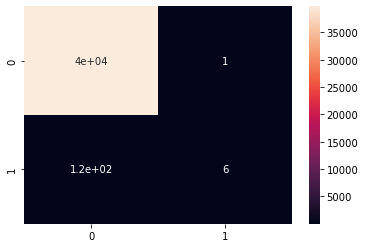

In [53]:
#Train, test split, try different models, pick best model.
#model_threat = LogisticRegression()
#model_threat = SVC()
model_threat = RandomForestClassifier()

vec_tf = TfidfVectorizer(ngram_range=(1,2), stop_words="english", strip_accents="unicode")
svd_tmp = TruncatedSVD(n_components=10)
y_threat = np.array(df["threat"]).reshape(-1,1)
x_threat = df["comment_text"]

X_train, X_test, y_train, y_test = train_test_split(x_threat, y_threat)

pipe_threat = Pipeline([("vect", vec_tf),("svd", svd_tmp),("model", model_threat)])


pipe_threat.fit(X_train, y_train.ravel())
pred_threat = pipe_threat.predict(X_test)

print(classification_report(y_test, pred_threat))
sns.heatmap(confusion_matrix(y_test, pred_threat), annot=True)

### Predictive Model For 'Insult'

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     37929
           1       0.82      0.50      0.62      1964

    accuracy                           0.97     39893
   macro avg       0.90      0.75      0.80     39893
weighted avg       0.97      0.97      0.97     39893



<AxesSubplot:>

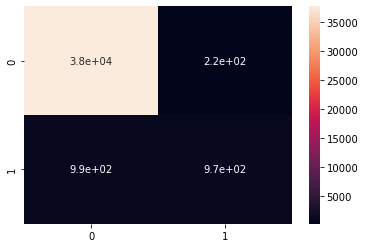

In [39]:
#Train, test split, try different models, pick best model.
model_insult = LogisticRegression()
#model_insult = SVC()
#model_insult = RandomForestClassifier()

vec_tf = TfidfVectorizer(ngram_range=(1,2), stop_words="english", strip_accents="unicode")
#svd_tmp = TruncatedSVD(n_components=10)
y_insult = np.array(df["insult"]).reshape(-1,1)
x_insult = df["comment_text"]

X_train, X_test, y_train, y_test = train_test_split(x_insult, y_insult)

pipe_insult = Pipeline([("vect", vec_tf),("model", model_insult)])


pipe_insult.fit(X_train, y_train.ravel())
pred_insult = pipe_insult.predict(X_test)

print(classification_report(y_test, pred_insult))
sns.heatmap(confusion_matrix(y_test, pred_insult), annot=True)

### Predictive Model For 'Identity_Hate'

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     39572
           1       0.62      0.16      0.25       321

    accuracy                           0.99     39893
   macro avg       0.81      0.58      0.62     39893
weighted avg       0.99      0.99      0.99     39893



<AxesSubplot:>

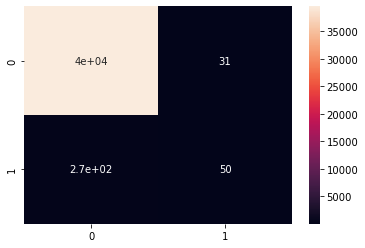

In [40]:
#Train, test split, try different models, pick best model.
model_identity = LogisticRegression()
#model_identity = SVC()
#model_identity = RandomForestClassifier()

vec_tf = TfidfVectorizer(ngram_range=(1,2), stop_words="english", strip_accents="unicode")
#svd_tmp = TruncatedSVD(n_components=10)
y_identity = np.array(df["identity_hate"]).reshape(-1,1)
x_identity = df["comment_text"]

X_train, X_test, y_train, y_test = train_test_split(x_identity, y_identity)

pipe_identity = Pipeline([("vect", vec_tf),("model", model_identity)])


pipe_identity.fit(X_train, y_train.ravel())
pred_identity = pipe_identity.predict(X_test)

print(classification_report(y_test, pred_identity))
sns.heatmap(confusion_matrix(y_test, pred_identity), annot=True)

### Predictive Model For 'None'

              precision    recall  f1-score   support

           0       0.94      0.55      0.70      4109
           1       0.95      1.00      0.97     35784

    accuracy                           0.95     39893
   macro avg       0.95      0.77      0.83     39893
weighted avg       0.95      0.95      0.94     39893



<AxesSubplot:>

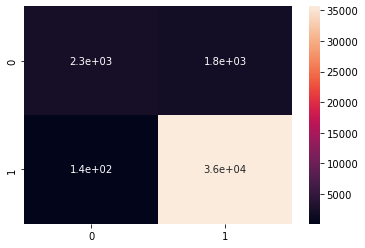

In [41]:
#Train, test split, try different models, pick best model.
model_none = LogisticRegression()
#model_none = SVC()
#model_none = RandomForestClassifier()

vec_tf = TfidfVectorizer(ngram_range=(1,2), stop_words="english", strip_accents="unicode")
#svd_tmp = TruncatedSVD(n_components=10)
y_none = np.array(df["none"]).reshape(-1,1)
x_none = df["comment_text"]

X_train, X_test, y_train, y_test = train_test_split(x_none, y_none)

pipe_none = Pipeline([("vect", vec_tf),("model", model_none)])


pipe_none.fit(X_train, y_train.ravel())
pred_none = pipe_none.predict(X_test)

print(classification_report(y_test, pred_none))
sns.heatmap(confusion_matrix(y_test, pred_none), annot=True)

## Test Data

In [42]:
#Visualize test data
test_df = pd.read_csv("test.csv")
test_df.head()

,id,comment_text
0,1,Yo bitch Ja Rule is more succesful then you'll...
1,2,== From RfC == \n\n The title is fine as it is...
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,4,":If you have a look back at the source, the in..."
4,5,I don't anonymously edit articles at all.


In [43]:
#Predict categories for test data
test_pred_toxic = pipe_toxic.predict(test_df["comment_text"])
test_pred_severe = pipe_severe.predict(test_df["comment_text"])
test_pred_obscene = pipe_obscene.predict(test_df["comment_text"])
test_pred_threat = pipe_threat.predict(test_df["comment_text"])
test_pred_insult = pipe_insult.predict(test_df["comment_text"])
test_pred_identity = pipe_identity.predict(test_df["comment_text"])
test_pred_none = pipe_none.predict(test_df["comment_text"])


In [44]:
#Add results of predictions to test dataset
test_df["toxic"] = test_pred_toxic
test_df["severe_toxic"] = test_pred_severe
test_df["obscene"] = test_pred_obscene
test_df["threat"] = test_pred_threat
test_df["insult"] = test_pred_insult
test_df["identity_hate"] = test_pred_identity
test_df["none"] = test_pred_none
test_df.head()



,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
0,1,Yo bitch Ja Rule is more succesful then you'll...,1,0,1,0,1,0,0
1,2,== From RfC == \n\n The title is fine as it is...,0,0,0,0,0,0,1
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0,0,0,0,1
3,4,":If you have a look back at the source, the in...",0,0,0,0,0,0,1
4,5,I don't anonymously edit articles at all.,0,0,0,0,0,0,1


In [45]:
#Convert test dataframe into .csv file
test_df.to_csv('out.csv', index=False)

### Summary

Tried a few models for each target, SVC takes forever to run and accuracy is low for many targets. Logistic regression or random forest classifier has better accuracy. Picked best predictive model for each target and used it to predict test dataset. Also added a 'None' column to training dataset to predict comments that didn't fit any of the original features. 

## Output Details, Submission Info, and Example Submission

For this project, please output your predictions in a CSV file. The structure of the CSV file should match the structure of the example below. 

The output should contain one row for each row of test data, complete with the columns for ID and each classification.

Into Moodle please submit:
<ul>
<li> Your notebook file(s). I'm not going to run them, just look. 
<li> Your sample submission CSV. This will be evaluated for accuracy against the real labels; only a subset of the predictions will be scored. 
</ul>

It is REALLY, REALLY, REALLY important the the structure of your output matches the specifications. The accuracies will be calculated by a script, and it is expecting a specific format. 

### Sample Evaluator

The file prediction_evaluator.ipynb contains an example scoring function, scoreChecker. This function takes a sumbission and an answer key, loops through, and evaluates the accuracy. You can use this to verify the format of your submission. I'm going to use the same function to evaluate the accuracy of your submission, against the answer key (unless I made some mistake in this counting function).

In [46]:
#Construct dummy data for a sample output. 
#You won't do this part first, you have real data - I'm faking it. 
#Your data should have the same structure, so the CSV output is the same
dummy_ids = ["dfasdf234", "asdfgw43r52", "asdgtawe4", "wqtr215432"]
dummy_toxic = [0,0,0,0]
dummy_severe = [0,0,0,0]
dummy_obscene = [0,1,1,0]
dummy_threat = [0,1,0,1]
dummy_insult = [0,0,1,0]
dummy_ident = [0,1,1,0]
columns = ["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
sample_out = pd.DataFrame( list(zip(dummy_ids, dummy_toxic, dummy_severe, dummy_obscene, dummy_threat, dummy_insult, dummy_ident)),
                    columns=columns)
sample_out.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,dfasdf234,0,0,0,0,0,0
1,asdfgw43r52,0,0,1,1,0,1
2,asdgtawe4,0,0,1,0,1,1
3,wqtr215432,0,0,0,1,0,0


In [47]:
#Write DF to CSV. Please keep the "out.csv" filename. Moodle will auto-preface it with an identifier when I download it. 
#This command should work with your dataframe of predictions. 
sample_out.to_csv('out.csv', index=False)  

## Grading

The grading for this is split between accuracy and well written code:
<ul>
<li> 75% - Accuracy. The most accurate will get 100% on this, the others will be scaled down from there. 
<li> 25% - Code quality. Can the code be followed and made sense of - i.e. comments, sections, titles. 
</ul>